# Feature extraction part 2 - Maeda et al. 2012 baseline FHR, accelerations and decelerations

This notebook contains on from `12_feature_extraction.ipynb`, looking at replicating some of the other methods in the FHRMA toolbox. As my first attempt to replicate Taylor et al. 2000 didn't match FHRMA - likely due to the differences in the Butterworth filter - I instead below tried a simpler method that just splits up the data and takes average, and compared against FHRMA results.

**Some observations to be aware of:**
* This method used modes, but that meant the baseline FHR would vary quite notably if the mode changed (as it's not uncommon for it to be a close call between modes). For example, which mode is chosen in a multi-mode situation. I have found examples where FHRMA was the min and examples where it was the max.
* In the calculation of baseline FHR and detection of accelerations and decelerations, I have noted points where I think FHRMA's implementation differs from that described in the paper from Maeda et al. 2012. These include:
    * Calculation of mean from all values in bin rather than 5-minute interval values in bin (as I think it makes sense it would be the interval)
    * Calculation of fHR for last interval using points from the previous interval to pad to 150 (as I have not found mention of this in the paper - but its not implausible)
    * Excluding reference lines in accelerations/decelerations (as these are described in the paper as being used)
* There appears to be issues with some of the uploaded files - when viewed in Python or Octave, they contain alot of 0s (if not entirely 0s) - yet the FHRMA results appear to be fine.
* When files containing 0s are processed on Octave, it hits an error.

In [1]:
# Import packages
from dataclasses import dataclass
import glob
from itertools import compress, groupby
import matplotlib.pyplot as plt
import math
import numpy as np
import os
import pandas as pd
from scipy import io
from statistics import multimode

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    fhrma_train_csv = './fhrma/train_test_data/traindata_csv/'
    fhrma_test_csv = './fhrma/train_test_data/testdata_csv/'


paths = Paths()

## Maeda et al. 2012 Baseline FHR

[Maeda et al. 2012](https://benthamopen.com/contents/pdf/TOMDJ/TOMDJ-4-28.pdf) - Central Computerized Automatic Fetal Heart Rate Diagnosis with a Rapid and Direct Alarm System

FHR was sampled every 250ms over a 5-minute period, and averaged every 2 seconds to determine 150 FHR (also found 150 uterine contraction data) (as there are 30 x 2 seconds in a minute, so 150 x 2 seconds in 5 minutes). FHR data were counted in intervals of 10 beats per minute (bpm) ranging from 0 to 200 bpm. The data in the interval with the most frequent FHR data was then averaged to determine the FHR baseline. 

So basically...

1. **Find the average of every 2 seconds**

2. **Look at data from a five minute period** - this will mean you are looking at a sample of 150 FHR (as each represents average of 2 seconds, and there are 150 x 2 seconds in 5 minutes)

3. **Look at frequency of data in bins of 10bpm** - i.e. number of FHR that are 140-149.99, 150-150.99, and so on.

4. **Find the most frequent bin** - for example, 140-150 has the most records, then just use the data from that bin

5. **Find the average of the heartrates from that bin** - so might get a result like 145.5, or so on. That represents the baseline FHR for that 5 minute portion of the data.

### MATLAB Implementation

Boudet et al. implement this method [in the FHRMA toolbox using MATLAB](https://github.com/utsb-fmm/FHRMA/blob/master/aammaeda.m), and this is copied below:

```
sFHR=avgsubsamp(FHR,8);
baseline=zeros(1,length(FHR));

for win=[0:150:length(sFHR)-151 length(sFHR)-150]
    
    bins=zeros(1,25);

    for i=1:150
        bins(ceil(sFHR(win+i)/10))=bins(ceil(sFHR(win+i)/10))+1;
    end
    [~,bestbins]=max(bins(1:20));
    
    baseline(win*8+1:win*8+1200)=mean(sFHR( sFHR<=bestbins*10 & sFHR>(bestbins-1)*10 ));

end


baseline(win*8+1201:length(FHR))=baseline(win*8+1200);
```

They use a function `avgsubsamp` for subsampling by average, which is also copied below:

```
function y=avgsubsamp(x,factor)
    y=zeros(1,floor(length(x)/factor));
    for i=1:length(y)
        y(i)=mean(x((i-1)*factor+1:i*factor));
    end
end
```

### Python Implementation

#### Set up

Load the FHRMA data - the raw FHR trace, and the results from their implementation of this method on that same trace.

In [3]:
# Load the FHR
fhr = pd.read_csv(os.path.join(paths.fhrma_train_csv, 'train42.csv'),
                  header=None)[0].values
fhr[0:10]

array([153.  , 153.  , 153.25, 157.5 , 157.5 , 157.5 , 155.25, 155.25,
       153.75, 153.75])

In [4]:
# Load FHRMA version of results
md_std = io.loadmat('./fhrma/MD_std.mat')

# Get array listing filenames (and hence order of the data)
fhrma_files = np.concatenate(np.concatenate(md_std['data']['filename']))

# Get array with the baseline signal as per Maeda when implemented in FHRMA
fhrma_md = np.concatenate(md_std['data']['baseline'])

# Convert array into dictionary so each record is accompanied by relevant name
fhrma_maeda_base = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md[i][0] for i in range(len(fhrma_files))}

# Extract the same result as I am currently processing
fhrma_result = fhrma_maeda_base['train42']

#### Define function that replicates Maeda et al. 2012

Steps:

1. **Convert to average of every 2 seconds** - In FHRMA, they seperate the FHR into chunks of 8 (i.e. first 8 records, then next 8, then next 8, and so on). They then find the mean of each of those chunks.

2. **Find the most common heartrate bin in each 5 minute interval** - We're looking at every 5 minutes / 300 seconds (which equates to 150 of the 2 second results). We sort the heartrates into bins of 10bpm (e.g. 130-140, 140-150, 150-160), then look to see which bin is most common for that 5 minute period. FHRMA then find the mean of all heartrates from that bin across the entire recorded FHR CTG, but I am minded to suggested that this should be the mean of only the heartrates from that bin in the current five minute interval.

Note: This doesn't clean FHR beforehand, so could include large periods of 0, and includes values outside of normal.

In [5]:
def get_baseline(fhr, match_fhrma, show_process=False):
    '''
    Get FHR baseline using method from Maeda et al. 2012.

    Parameters
    ----------
    fhr : array
        Raw FHR sampled at 4Hz
    match_fhrma : boolean
        Whether to use a method that ensures results match FHRMA implementation
        of Maeda's method, or whether to use the method that I currently think
        best matches the description/intention in the original paper
    show_process : boolean
        Whether to print results as move through this process

    Return
    ------
    baseline : array
        Array where raw FHR is replaced by the baseline FHR calculated for the
        five minute interval which it belonged to
    '''
    # Create array of zeros of length of fhr, which will amend to store baseline
    baseline = [0] * len(fhr)

    # Find mean of every 8 records, generating shorter version of FHR (sfhr)
    sfhr = []
    start=0
    end=len(fhr)
    step=8
    for i in range(start, end, step):
        sfhr.append(np.mean(fhr[i:i+step]))

    # If there is a remainder when divide length by 8 (i.e. doesn't perfectly
    # divide), then drop the final calculated FHR, as it is not from at least 8 data points
    if len(fhr) % 8 != 0:
        sfhr.pop()

    # Print example of results
    if show_process:
        print(f'First 16 records in raw FHR: {fhr[:16]}')
        print(f'First 2 records in shortened FHR (average of each 8): {sfhr[:2]}')

    # Split the record into 5 minute intervals (if last less than 5 min, will be 
    # smaller). Loop through each interval
    for i in range(0, len(sfhr), 150):

        # If want to match results in FHRMA, for the final interval, filter to
        # the last 5 minutes of the data, even if that overlaps with the
        # previous 5 minute segment
        if match_fhrma:
            current = sfhr[0+i:150+i]
            if len(current) < 150:
                current = sfhr[-150:]
        # Otherwise, allow the last segment to be less than 5 minutes
        else:
            # Filter data to that 5-minute segment
            current = sfhr[0+i:150+i]

        # Convert each record into their upper bin boundary (e.g. 149 --> 150)
        bins = [math.ceil(x/10)*10 for x in current]

        # Find the most common bin - in multi-mode situations, not yet certain
        # on whether there is one method that would match all in FHRMA (have
        # found some examples where they took min and some where they took max)
        modes = multimode(bins)
        most_common = modes[len(modes)-1]
        if show_process:
            print(most_common)

        # If want to match results in FHRMA, filter to records from that bin
        # from across the entire CTG
        if match_fhrma:
            mask = [(x <= most_common) & (x > most_common-10) for x in sfhr]
            filtered = list(compress(sfhr, mask))
        # Otherwise, filter to records in that bin from only that 5min interval
        else:
            mask = [(x <= most_common) & (x > most_common-10) for x in current]
            filtered = list(compress(current, mask))

        # Find mean of those filtered records in that bin
        mean = np.mean(filtered)

        # Set the records in baseline for that five minute interval to this mean
        baseline[0+(i*8):1200+(i*8)] = [mean] * 1200

    # Trim results to match original FHR length (as will overfill final small interval)
    baseline = baseline[:len(fhr)]

    # Print example of results from final run of that loop above
    if show_process:
        print(f'First 10 records of one of the intervals: {current[:10]}')
        print(f'Conversion of those records to bins: {bins[:10]}')
        print(f'Most common bin in the whole 5 minute interval: {most_common}')
        print(f'Calculated baseline FHR for that interval: {mean}')

    return(baseline)

#### Compare to FHRMA

Example where print results from throughout process, to help see/understand what calculations were performed...

In [6]:
# Result from above where match_fhrma=False
python_result_nomatch = get_baseline(fhr, match_fhrma=False, show_process=False)
[(k, sum(1 for i in g)) for k,g in groupby(python_result_nomatch)]

[(156.07233796296296, 1200),
 (145.53977272727272, 1200),
 (154.0015120967742, 1200),
 (155.8308823529412, 1200),
 (145.99186643835617, 1200),
 (155.69320652173914, 1200),
 (156.1013392857143, 1200),
 (0.0, 15600),
 (166.02102272727274, 1200),
 (163.95, 1200),
 (165.84881756756758, 1200),
 (163.148125, 1200),
 (0.0, 4773)]

In [7]:
# Results when match_fhrma=True
python_result_match = get_baseline(fhr, match_fhrma=True, show_process=False)
[(k, sum(1 for i in g)) for k,g in groupby(python_result_match)]

[(155.1784375, 1200),
 (145.6932304400978, 1200),
 (155.1784375, 2400),
 (145.6932304400978, 1200),
 (155.1784375, 2400),
 (0.0, 15600),
 (164.231686827957, 4800),
 (0.0, 4773)]

In [8]:
# View counts of consecutive equal values from FHRMA
[(k, sum(1 for i in g)) for k,g in groupby(fhrma_result)]

[(154.93729975863593, 1200),
 (145.6740900851646, 1200),
 (154.93729975863593, 2400),
 (145.6740900851646, 1200),
 (154.93729975863593, 1200),
 (164.59630620059292, 4800),
 (145.6740900851646, 1200),
 (154.93729975863593, 2400),
 (145.6740900851646, 2400),
 (154.93729975863593, 1200),
 (145.6740900851646, 1200),
 (154.93729975863593, 1200),
 (145.6740900851646, 2400),
 (164.59630620059292, 4800),
 (125.10443440642288, 1200),
 (65.80757343372373, 1200),
 (185.91304895141195, 1168),
 (194.90725635593222, 1205)]

In [9]:
# View the mean of each
print(np.mean(python_result_match))
print(np.mean(fhrma_result))

61.628286862372384
153.3106358239806


In [10]:
# Find mean of every 8 records, generating shorter version of FHR (sfhr)
sfhr = []
start=0
end=len(fhr)
step=8
for i in range(start, end, step):
    sfhr.append(np.mean(fhr[i:i+step]))

# If there is a remainder when divide length by 8 (i.e. doesn't perfectly
# divide), then drop the final calculated FHR, as it is not from at least 8 data points
if len(fhr) % 8 != 0:
    sfhr.pop()

print(len(sfhr))

4196


In [11]:
sfhr[:150]

[155.28125,
 152.125,
 154.40625,
 155.125,
 147.84375,
 151.0625,
 154.84375,
 154.84375,
 151.0625,
 158.84375,
 159.40625,
 159.3125,
 158.0625,
 154.71875,
 150.46875,
 156.40625,
 154.75,
 156.875,
 159.5625,
 160.90625,
 159.78125,
 159.75,
 157.6875,
 157.96875,
 159.125,
 156.34375,
 155.53125,
 159.65625,
 158.875,
 158.21875,
 157.78125,
 160.125,
 160.90625,
 162.125,
 159.6875,
 158.46875,
 156.875,
 153.75,
 160.28125,
 164.09375,
 164.125,
 163.28125,
 162.375,
 162.09375,
 161.6875,
 160.0,
 158.8125,
 158.75,
 159.15625,
 159.34375,
 160.9375,
 160.125,
 157.34375,
 160.5625,
 161.21875,
 158.09375,
 153.4375,
 153.375,
 152.125,
 142.53125,
 144.53125,
 147.25,
 160.40625,
 134.25,
 109.03125,
 126.0625,
 137.59375,
 141.21875,
 137.625,
 129.875,
 124.9375,
 124.8125,
 120.125,
 121.4375,
 121.25,
 116.625,
 107.25,
 105.15625,
 101.125,
 100.71875,
 89.15625,
 87.40625,
 87.9375,
 89.3125,
 83.0625,
 83.71875,
 82.5625,
 76.4375,
 82.84375,
 83.4375,
 84.3125,
 76.75

#### Test on all available FHRMA data and compare against their results

For this, I took the overall mean from the baseline record (rather than comparing each of the 5-minute means).

First, import all the FHRMA data. As in `13_feature_extraction_taylor_2000.ipynb`, remove the blank records (which are not blank for FHRMA, for some reason, but are for me).

In [12]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict
    Inputs:
    directory - string, location of csv files
    output_dict - dictionary, to save files to
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary
        output_dict[name] = pd.read_csv(file, header=None)[0].values

    return output_dict

# Import training csv files
raw_fhr = import_csv(
    directory=paths.fhrma_train_csv,
    output_dict=dict())

# Import test csv files and add to same dictionary
raw_fhr = import_csv(
    directory=paths.fhrma_test_csv,
    output_dict=raw_fhr)

# Drop blank files from raw FHR and FHRMA Maeda dictionaries, or files that are
# majority blank (and yet seem to have answers in the FHRMA results)
blank = ['train40', 'train57', 'test03', 'test10', 'test21', 'test27', 'test28',
         'test34', 'test37', 'test41', 'test43', 'test51', 'test62', 'test71',
         'test75', 'test50', 'train39', 'train12', 'train35', 'train46',
         'train49', 'test12', 'test35', 'test49']
for k in blank:
    raw_fhr.pop(k)
    fhrma_maeda_base.pop(k)

Then, apply my implementation of Maeda and compare results

In [13]:
# Create dictionary to store results
python_maeda = dict()

for key, value in raw_fhr.items():
    python_maeda[key] = get_baseline(value, match_fhrma=True, show_process=False)

In [14]:
# Find mean of each record and combine dataframes
python_df = pd.DataFrame({
    'record': python_maeda.keys(),
    'python_mean': [np.mean(python_maeda[i]) for i in python_maeda.keys()]})
fhrma_df = pd.DataFrame({
    'record': fhrma_maeda_base.keys(),
    'fhrma_mean': [np.mean(fhrma_maeda_base[i]) for i in fhrma_maeda_base.keys()]})
compare_mean = pd.merge(python_df, fhrma_df, on='record')
compare_mean.head()

,record,python_mean,fhrma_mean
0,train28,124.594527,124.594527
1,train04,138.870231,138.870231
2,train31,137.611639,137.611639
3,train13,131.197478,131.193660
4,train47,141.202107,141.194016


In [15]:
compare_mean[compare_mean['record'] == 'train01']

,record,python_mean,fhrma_mean
18,train01,164.472542,164.472542


In [16]:
compare_mean['diff'] = abs(compare_mean['python_mean'] - compare_mean['fhrma_mean'])
compare_mean.sort_values(by='diff', ascending=False).head()

,record,python_mean,fhrma_mean,diff
36,train42,61.628287,153.310636,91.682349
72,test05,96.446379,155.096793,58.650414
47,train56,82.196131,140.343148,58.147017
77,test20,94.478847,134.438045,39.959198
68,test26,127.366660,154.607964,27.241304


In [17]:
def compare_means(df, x, y, title):
    '''
    Create scatterpol comparing two columns from df.
    Inputs:
    df - dataframe, to plot from
    x - string, name of column for x axis
    y - string, name of column for y axis
    '''
    fig, ax = plt.subplots()
    ax.scatter(x=df[x], y=df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    #plt.xlim([100, 200])
    #plt.ylim([100, 200])
    plt.grid()
    ax.set_box_aspect(1)
    plt.show()

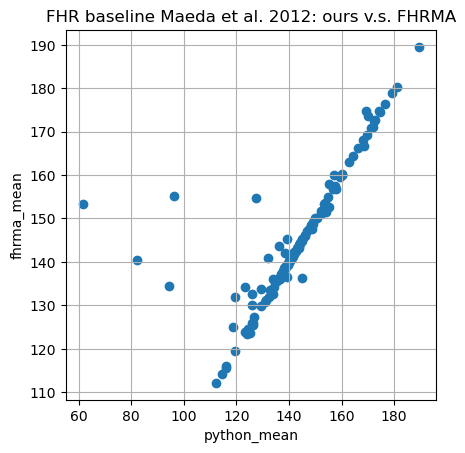

In [18]:
compare_means(compare_mean, 'python_mean', 'fhrma_mean',
              'FHR baseline Maeda et al. 2012: ours v.s. FHRMA')

## Maeda et al. 2012 Accelerations and Decelerations

Method description from the paper:
* **Reference line** - "Data-to-data difference in FHR were averaged (F bpm) and added to the baseline data to define the upper reference line (FHR baseline + F/2), and subtracted from the baseline data to define the lower reference line (FHR baseline –F/2)."
* **Deceleration** - "A transient FHR decrease of more than 15 bpm below the lower reference line lasting longer than 15 seconds was defined as a deceleration. An FHR decrease appearing during transient tachycardia with a nadir of 110 bpm or more was not considered a deceleration but instead a transient recovery to the normal baseline."
* **Late Deceleration** - "The DIP SHAPE value was applied to the classification of deceleration, and was calculated by dividing the dip area ((sum of the FHR data in the deceleration) x 2) by ((deceleration amplitude x duration (seconds)) (Fig. 2). A decrease in FHR was defined as late deceleration (LD) if the following four conditions were met within 15 minutes: (1) the lag time between the contraction peak and FHR nadir was longer than 20 seconds in 60 % or more decelerations: (2) the number of deceleration was more than the contraction number – 1: (3) the DIP SHAPE value was less than 0.5: and (4) the dip variability (sum of FHR n – FHR n-1 in the deceleration) was less than 60 bpm). A decrease in FHR was defined as early deceleration (ED) if the DIP SHAPE value was less than 0.5, dip irregularity was less than 60 bpm and the lag time was almost zero."
* **Variable Deceleration** - "A decrease in FHR was defined as a variable deceleration (VD) if the DIP SHAPE was greater than 0.6 and dip variability was greater than 60 bpm"
* **Severe variable Deceleration** - A variable deceleration with a nadir heart rate less than 100 bpm and duration longer than 60 seconds was defined as severe variable deceleration (SVD)
* **Prolonged Deceleration** - Deceleration lasting longer than 2 minutes
* **Acceleration** - A transient rise in FHR of 15 bpm or more above the upper reference line lasting 15 seconds or more , after 30 weeks of pregnancy, was defined as FHR acceleration 

### MATLAB implementation

Boudet et al. implement this method [in the FHRMA toolbox using MATLAB](https://github.com/utsb-fmm/FHRMA/blob/master/aammaeda.m), and this is copied below. First, I have described my understanding of what this function is doing.

for accelerations, detect accident...
* signal = fhr - baseline
* threshold = 15
* peaks are where the signal is greater than the threshold
* find the start, end and maximum points of those accidents
* if segment is longer than 15 seconds (15*4) then it is classed as an accident

minus int...
* a = outcome of detect accident
* f = rerun detect accident but with threshold of 5
* removes elements from f that are also in a

it does likewise for decelerations, but instead, signal = baseline - fhr.

They state that Maeda's method for acceleration and deceleration detection is the same as the standard simple method used in their toolbox.

<mark>this appears to exclude the paper's concept of reference lines, which is ambiguous, but i think might be about finding the average difference between each 2second bpm HR reading and adding that to the 15bpm difference required from baseline</mark>

```
function [acc,dec,falseacc,falsedec]=simpleaddetection(fhr,baseline)

acc=detectaccident(fhr-baseline,15);
dec=detectaccident(baseline-fhr,15);
falseacc=minusint(acc,detectaccident(fhr-baseline,5));
falsedec=minusint(dec,detectaccident(baseline-fhr,5));
end

function accidentsample=detectaccident(sig,thre)

peaks=find(sig>thre);
accidentsample=zeros(3,0);
while ~isempty(peaks)
    dacc=find(sig(1:peaks)<0,1,'last');
    if isempty(dacc)
        dacc=1;
    end
    facc=find(sig(dacc+1:end)<0,1,'first')+dacc;
    if isempty(facc)
        facc=length(sig);
    end
    [~,macc]=max(sig(dacc:facc));
    macc=macc+dacc-1;
    if facc-dacc>15*4
        accidentsample=[accidentsample [dacc;facc;macc]/4];
    end   
    peaks=peaks(peaks>facc);
end
end

function f=minusint(a,f)

for i=1:size(a,2)
    n=find(f(1,:)>=a(1,i) &f(2,:)<=a(2,i));
    if ~isempty(n)
        f=f(:,[1:n-1 n+1:end]);
    end
end
    
end
```

### Python implementation

I have used the baseline from the FHRMA toolbox when calculating accelerations and decelerations so I can validate the method, regardless of whether my baseline methodology produced an exact match.

#### Load data

In [19]:
# Get FHRMA results
fhrma_md_acc = np.concatenate(md_std['data']['accelerations'])

# Convert array into dictionary so each record is accompanied by relevant name
fhrma_maeda_acc = {
    fhrma_files[i].replace('.fhr', ''): 
    fhrma_md_acc[i] for i in range(len(fhrma_files))}

#### Define function for detecting accelerations or decelerations

In [20]:
def detect_accident(sig, thre):
    '''
    Detect accelerations or decelerations by comparing difference betweeen FHR
    and FHR baseline against a specified threshold.

    Parameters:
    -----------
    sig: array
        Difference between signal and baseline - for accelerations this is
        fhr-baseline, and for decelerations this is baseline-fhr
    thre: int
        Threshold for difference

    Outputs:
    --------
    result: dataframe
        Dataframe with the time in seconds where a peak start and began, and 
        index for the maximum of the peak (and for decelerations, this is
        referring to a trough and the max of that trough)
    '''
    # Create empty list to store result
    res = []

    # Find points where value is greater than the threshold
    peaks = np.argwhere(sig > thre).ravel()

    # While we have points in peaks
    while len(peaks) > 0:

        # Extract all of sig before the first peak
        before = sig[:peaks[0]]

        # Find index of last point before peak that is < 0
        # E.g. For accelerations, last point where FHR is not past baseline
        dacc = np.argwhere(before < 0).ravel()
        if len(dacc) > 0:
            dacc = dacc[-1]
        else:
            dacc = 1

        # Extract all of signal after that point
        after = sig[dacc+1:]

        # Find index of first point after then that is < 0
        # Adding dacc+1 to convert it to actual location in signal (not just after peak)
        facc = np.argwhere(after < 0).ravel()
        if len(facc > 0):
            facc = facc[0] + dacc + 1
        else:
            facc = len(sig)-1

        # Filter to the values between dacc and facc (so array just has values > 0)
        interval = sig[dacc+1:facc]

        # Find the index of the maximum value in that interval
        # Adding dacc+1 to convert it to actual location in signal
        macc = np.argmax(interval) + dacc + 1

        # Check if length of interval is more than 15 seconds - if so, save result,
        # dividing each value by 4 so it is in seconds rather than quarter seconds -
        # and by 60 so it is in minutes rather than seconds - and plus 1 so it
        # matches the MATLAB results (as that is 1-indexed)
        if len(interval) >= 15*4:
            res.append([(x+1)/4/60 for x in [dacc, facc, macc]])

        # Filter to peaks that fall after interval explored
        peaks = peaks[peaks > facc]

    # Convert result to dataframe
    result = pd.DataFrame(res, columns=['start', 'end', 'max'])

    return (result)

**Note:** Have added some pre-processing as suspect that might be reason for differences - they do a few different things, for now just added linear interpolation. The Maeda paper doesn't mention pre-processing, but from looking into FHRMA, it appears they might have done it before running all the paper functions anyway.

In [21]:
def linear_interpolate(signal):
    '''
    Replace NaN using linear interpolation. For NaN at start or end of signal,
    replace with the first or last non-missing value
    Inputs:
    signal - Series
    '''
    # Set 0 to NaN
    signal[signal==0] = np.nan

    # Perform linear interpolation
    new_sig = signal.interpolate(method='linear')

    # If NaN fall at the start or end, set them as the first non-missing or last
    # non-missing value
    first_valid = new_sig.first_valid_index()
    new_sig[new_sig.index < first_valid] = new_sig[first_valid]
    last_valid = new_sig.last_valid_index()
    new_sig[new_sig.index > last_valid] = new_sig[last_valid]

    return new_sig

#### Test on single records (inc. false acc)

In [22]:
fhr = raw_fhr['train47']

# Perform linear interpolation on FHR
fhri = linear_interpolate(pd.Series(fhr)).to_numpy()

# Get baseline for that record
baseline = fhrma_maeda_base['train47']

# Get acceleration result from FHRMA for that record
fhrma_result = fhrma_maeda_acc['train47']

# Use function to get my result for accelerations
acc_df = detect_accident(fhri-baseline, 15)

# Find false accelerations
false_acc_m = detect_accident(fhri-baseline, 5)[['start', 'end']].to_numpy()

# Look for when acc falls within false_acc_m (ie. start >= false start, and 
# end <= false end) and remove those from acc
for i in np.arange(0, len(false_acc_m)):
    false_start = false_acc_m[i][0]
    false_end = false_acc_m[i][1]
    mask = ((acc_df['start'] >= false_start) & (acc_df['start'] <= false_end))
    acc_df = acc_df[~mask]

<mark>issue: false_acc more than find in octave and causing us to lose everything</mark>

In [23]:
acc_df

,start,end,max


In [24]:
false_acc_m

array([[  2.34583333,   2.87083333],
       [  3.15833333,   3.675     ],
       [  4.94583333,   5.44583333],
       [  7.12083333,   7.75      ],
       [  9.01666667,   9.4875    ],
       [ 10.54583333,  10.92083333],
       [ 11.325     ,  11.87916667],
       [ 13.99166667,  14.4375    ],
       [ 14.44166667,  14.7       ],
       [ 15.65416667,  16.46666667],
       [ 16.84583333,  17.12916667],
       [ 17.17083333,  17.5875    ],
       [ 19.475     ,  20.025     ],
       [ 20.025     ,  20.79166667],
       [ 21.18333333,  21.6125    ],
       [ 23.00833333,  23.30416667],
       [ 23.7       ,  24.64583333],
       [ 27.55416667,  27.94166667],
       [ 28.24166667,  28.525     ],
       [ 28.52916667,  28.83333333],
       [ 28.84166667,  29.8       ],
       [ 30.03333333,  30.39166667],
       [ 31.225     ,  31.97916667],
       [ 33.34166667,  34.35      ],
       [ 37.625     ,  38.09166667],
       [ 38.14166667,  38.6125    ],
       [ 39.51666667,  39.80416667],
 

#### Test on all results and compare against FHRMA

Run on all results.

In [25]:
res = []

for record, fhr in raw_fhr.items():

    # Perform linear interpolation on FHR
    fhri = linear_interpolate(pd.Series(fhr)).to_numpy()

    # Get baseline for that record
    baseline = fhrma_maeda_base[record]

    # Get acceleration result from FHRMA for that record
    fhrma_result = fhrma_maeda_acc[record]

    # Use function to get my result for accelerations
    python_result = detect_accident(fhri-baseline, 15)[['start', 'end']].to_numpy()

    # Check if all match
    match = np.array_equal(fhrma_result, python_result)

    # Store in results
    res.append([record, fhrma_result, python_result, match])

# Convert to dataframe
result = pd.DataFrame(res, columns=['record', 'fhrma', 'python', 'match'])

Preview dataframe and number of differences and an example.

In [26]:
result.head()

,record,fhrma,python,match
0,train28,"[[9.9125, 11.091666666666667], [13.325, 14.779...","[[9.9125, 11.091666666666667], [13.325, 14.779...",True
1,train04,"[[4.125, 5.491666666666666], [7.3625, 10.50416...","[[4.125, 5.491666666666666], [7.3625, 10.50416...",True
2,train31,"[[19.225, 19.591666666666665], [20.325, 20.904...","[[19.225, 19.591666666666665], [20.325, 20.904...",True
3,train13,"[[11.2375, 11.616666666666667], [13.5, 15.7916...","[[11.2375, 11.616666666666667], [13.5, 15.7916...",True
4,train47,"[[2.345833333333333, 2.870833333333333], [4.94...","[[2.345833333333333, 2.870833333333333], [4.94...",False


In [27]:
result['match'].value_counts()

match
False    69
True     63
Name: count, dtype: int64

In [28]:
fhrma = result['fhrma'][4]
python = result['python'][4]

print(len(fhrma))
print(len(python))

24
28


Exploring number of differences and whether its always less (as I'm suspicious that remaining discrepancies are due to not yet implementing falseacc) - but below can see that's not the case

In [29]:
result['fhrma_len'] = [len(x) for x in result['fhrma']]
result['python_len'] = [len(x) for x in result['python']]

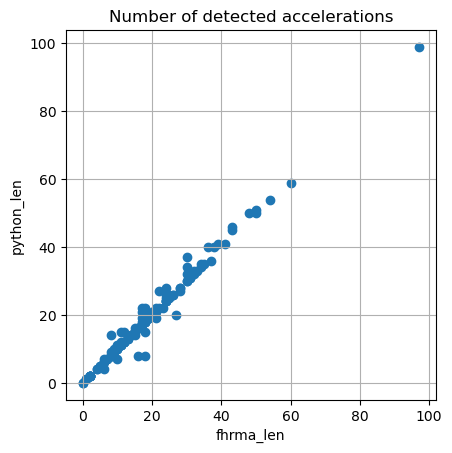

In [30]:
compare_means(result, 'fhrma_len', 'python_len',
              'Number of detected accelerations')